In [1]:
pip install --upgrade google-cloud-speech

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.3/284.3 kB 5.7 MB/s eta 0:00:00


In [1]:
pip install --upgrade google-cloud-storage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.17.3
    Uninstalling google-auth-2.17.3:
      Successfully uninstalled google-auth-2.17.3
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.8.0
    Uninstalling google-cloud-storage-2.8.0:
      Successfully uninstalled google-cloud-storage-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
google-colab 1.0.0 requires google-auth==2.17.3, but you have google-auth 2.27.0 which is incompatible.


In [2]:
import os
import pprint
from google.cloud import storage
from google.cloud import speech
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import urllib.parse
import requests
import json
import pandas as pd
from google.cloud import language_v1
import os
import numpy as np
import uuid
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set the environment variable
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "service-account.json"

In [3]:
# Initialize Firestore
cred = credentials.Certificate("service-account.json")

app = firebase_admin.initialize_app(cred)

db = firestore.client()


In [4]:
# Instantiates a client
client = language_v1.LanguageServiceClient()

def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    # bucket_name = "your-bucket-name"

    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)

    return blobs

In [5]:
def extract_audio_gcs(gcs_uri):
    """Asynchronously transcribes the audio file specified by the gcs_uri."""

    client = speech.SpeechClient()

    audio = speech.RecognitionAudio(uri=gcs_uri)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        audio_channel_count=2,
        language_code="en-US",
    )

    operation = client.long_running_recognize(config=config, audio=audio)

    print("Waiting for operation to complete...")
    response = operation.result(timeout=90)

    return response

In [16]:
from google.cloud import language_v1

def analyze_sentiment_text(text_content):
    """Analyzing Sentiment in a String"""

    client = language_v1.LanguageServiceClient()

    # The text to analyze
    document = language_v1.Document(content=text_content, type_=language_v1.Document.Type.PLAIN_TEXT)
    sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment

    print(f"Document sentiment score: {sentiment.score}")
    print(f"Document sentiment magnitude: {sentiment.magnitude}")

    return sentiment.score, sentiment.magnitude


In [8]:
from google.cloud import firestore

def add_to_firestore(filename, sentence_number, sentence_text, sentiment, magnitude, transcription_date):
    db = firestore.Client()

    doc_ref = db.collection(u'call_center_analyses').document()
    doc_ref.set({
        u'wav_filename': filename,
        u'sentence_number': sentence_number,
        u'sentence_text': sentence_text,
        u'sentiment': sentiment,
        u'magnitude': magnitude,
        u'transcription_date': transcription_date
    })


In [20]:
import datetime

def process_and_store_audio_text(response, blob_name):
    # Initialize an empty list to hold dictionaries of your data
    data_list = []

    sentence_number = 1
    for result in response.results:
        text_content = result.alternatives[0].transcript

        # Get sentiment score and magnitude
        sentiment_score, sentiment_magnitude = analyze_sentiment_text(text_content)

        # Add a dictionary for each sentence to the list
        data_list.append({
            'wav_filename': blob_name,
            'sentence_number': sentence_number,
            'sentence_text': text_content,
            'sentiment': sentiment_score,
            'magnitude': sentiment_magnitude,
            'transcription_date': str(datetime.date.today())
        })

        sentence_number += 1

    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(data_list)
    return df

In [13]:
def main():
     bucket_name = "speech_to_text_assignment_milton"
     blobs = list_blobs(bucket_name)

    # Note: The call returns a response only when the iterator is consumed.
     for blob in blobs:
        print(blob.name)

        # Extract audio from file
        gcs_uri = "gs://" + bucket_name + "/" + blob.name
        print("\nThis is the uri: {}".format(gcs_uri))

        response = extract_audio_gcs(gcs_uri=gcs_uri)
        pprint.pprint(response)

        # Inside your main function, after extracting audio text
        process_and_store_audio_text(response, blob.name)



In [19]:
#if __name__ == "__main__":
 # main()

Internet Service scenario (Call Center).wav

This is the uri: gs://speech_to_text_assignment_milton/Internet Service scenario (Call Center).wav
Waiting for operation to complete...
results {
  alternatives {
    transcript: "hello this is Joshua from hype ronery customer support how may I assist you today mrs. Johnson"
    confidence: 0.9726866483688354
  }
  result_end_time {
    seconds: 5
    nanos: 100000000
  }
  language_code: "en-us"
}
results {
  alternatives {
    transcript: " I\'m here to help mrs. Johnson I understand you\'ve been experiencing internet problems let\'s work through this together can you tell me have you noticed any construction or or any road work happening nearby recently"
    confidence: 0.9393397569656372
  }
  result_end_time {
    seconds: 23
    nanos: 220000000
  }
  language_code: "en-us"
}
results {
  alternatives {
    transcript: " I\'ve been some loud noises outside lately but I\'m not sure if it\'s related to this internet problem out of curiosi

In [21]:
if __name__ == "__main__":
    bucket_name = "speech_to_text_assignment_milton"
    blobs = list_blobs(bucket_name)

    # Assuming you want to process just the first audio file for demonstration
    for blob in blobs:
        print(f"Processing {blob.name}...")
        gcs_uri = f"gs://{bucket_name}/{blob.name}"
        response = extract_audio_gcs(gcs_uri=gcs_uri)
        df = process_and_store_audio_text(response, blob.name)

        # Display the DataFrame or perform further operations
        print(df)
        break  # Remove or comment out this line if you want to process all blobs


Processing Internet Service scenario (Call Center).wav...
Waiting for operation to complete...
Document sentiment score: -0.10000000149011612
Document sentiment magnitude: 0.8999999761581421
Document sentiment score: 0.0
Document sentiment magnitude: 0.10000000149011612
Document sentiment score: -0.30000001192092896
Document sentiment magnitude: 0.30000001192092896
Document sentiment score: -0.5
Document sentiment magnitude: 0.5
Document sentiment score: 0.0
Document sentiment magnitude: 0.0
Document sentiment score: 0.0
Document sentiment magnitude: 0.10000000149011612
Document sentiment score: 0.10000000149011612
Document sentiment magnitude: 0.5
Document sentiment score: 0.0
Document sentiment magnitude: 0.4000000059604645
Document sentiment score: 0.0
Document sentiment magnitude: 0.30000001192092896
Document sentiment score: 0.0
Document sentiment magnitude: 0.10000000149011612
Document sentiment score: 0.8999999761581421
Document sentiment magnitude: 1.7999999523162842
          

In [23]:
df.to_csv("speech_to_text.csv")

In [22]:
df

,wav_filename,sentence_number,sentence_text,sentiment,magnitude,transcription_date
0,Internet Service scenario (Call Center).wav,1,hello this is Joshua from hype ronery customer...,-0.1,0.9,2024-02-05
1,Internet Service scenario (Call Center).wav,2,I'm here to help mrs. Johnson I understand yo...,0.0,0.1,2024-02-05
2,Internet Service scenario (Call Center).wav,3,I've been some loud noises outside lately but...,-0.3,0.3,2024-02-05
3,Internet Service scenario (Call Center).wav,4,internet service went down completely okay th...,-0.5,0.5,2024-02-05
4,Internet Service scenario (Call Center).wav,5,my granddaughter plays the whole thing in the...,0.0,0.0,2024-02-05
5,Internet Service scenario (Call Center).wav,6,mrs. Johnson usually there are lights labeled...,0.0,0.1,2024-02-05
6,Internet Service scenario (Call Center).wav,7,sure. Let's focus on checking something else ...,0.1,0.5,2024-02-05
7,Internet Service scenario (Call Center).wav,8,I don't know what that no worries mrs. Johnso...,0.0,0.4,2024-02-05
8,Internet Service scenario (Call Center).wav,9,oh dear I see it now it was unplugged but I p...,0.0,0.3,2024-02-05
9,Internet Service scenario (Call Center).wav,10,mrs. Johnson according to our system your int...,0.0,0.1,2024-02-05


from matplotlib import pyplot as plt
df['sentence_number'].plot(kind='hist', bins=20, title='sentence_number')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['sentiment'].plot(kind='hist', bins=20, title='sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['magnitude'].plot(kind='hist', bins=20, title='magnitude')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='sentence_number', y='sentiment', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='sentiment', y='magnitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['sentence_number']
  ys = series['sentiment']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('sentence_number', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('sentence_number')
_ = plt.ylabel('sentiment')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['sentence_number']
  ys = series['magnitude']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('sentence_number', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('sentence_number')
_ = plt.ylabel('magnitude')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['sentence_number']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'sentence_number'}, axis=1)
              .sort_values('sentence_number', ascending=True))
  xs = counted['sentence_number']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('sentence_number', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('sentence_number')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['transcription_date']
  ys = series['sentiment']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('transcription_date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('transcription_date')
_ = plt.ylabel('sentiment')

from matplotlib import pyplot as plt
df['sentence_number'].plot(kind='line', figsize=(8, 4), title='sentence_number')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['sentiment'].plot(kind='line', figsize=(8, 4), title='sentiment')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['magnitude'].plot(kind='line', figsize=(8, 4), title='magnitude')
plt.gca().spines[['top', 'right']].set_visible(False)

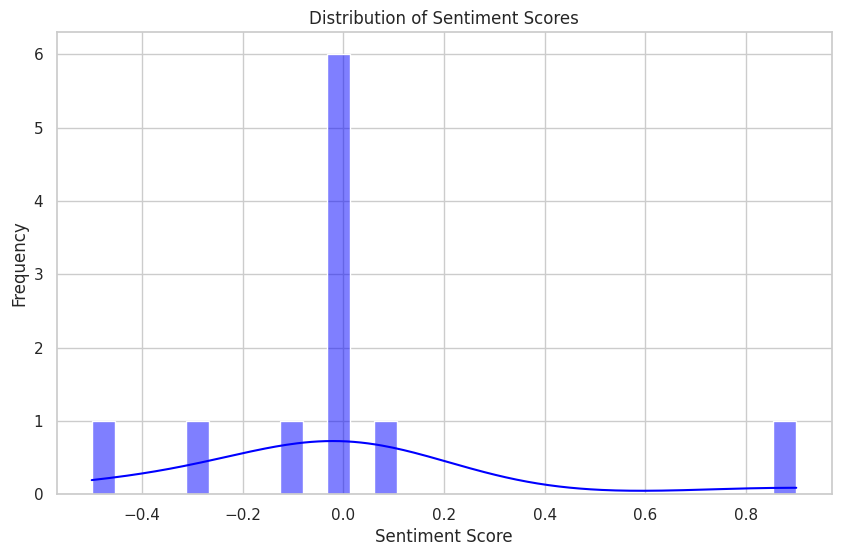

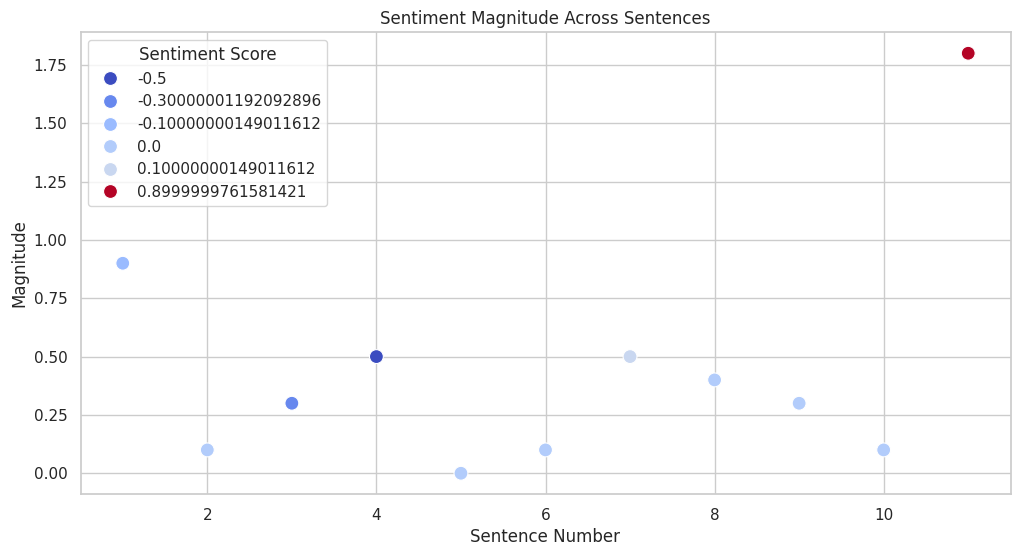

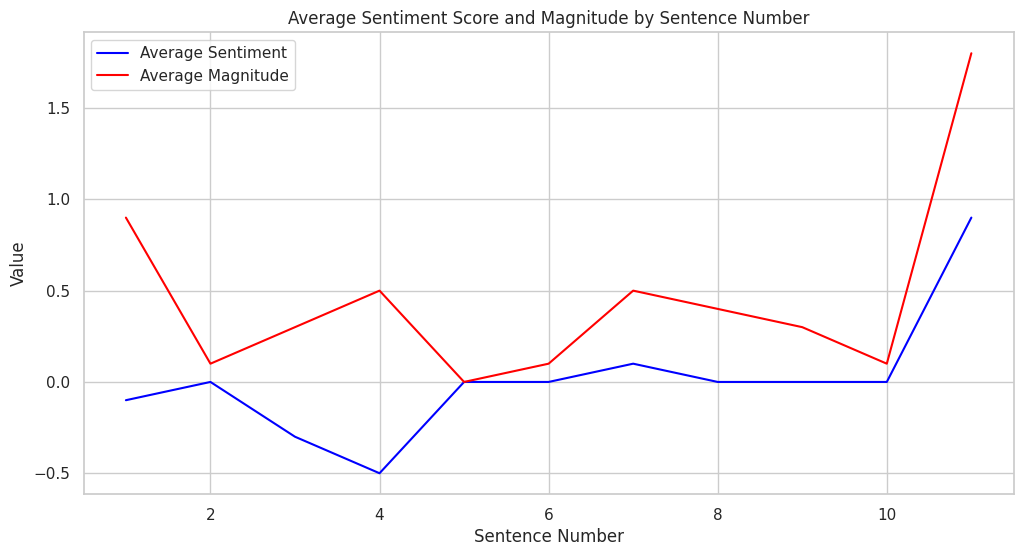

In [24]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Visualization 1: Distribution of Sentiment Scores
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Visualization 2: Sentiment Magnitude Across Sentences
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='sentence_number', y='magnitude', hue='sentiment', palette='coolwarm', s=100)
plt.title('Sentiment Magnitude Across Sentences')
plt.xlabel('Sentence Number')
plt.ylabel('Magnitude')
plt.legend(title='Sentiment Score')
plt.show()

# Visualization 3: Average Sentiment Score and Magnitude by Sentence Number
plt.figure(figsize=(12, 6))
grouped_df = df.groupby('sentence_number').agg({'sentiment':'mean', 'magnitude':'mean'}).reset_index()
sns.lineplot(data=grouped_df, x='sentence_number', y='sentiment', label='Average Sentiment', color='blue')
sns.lineplot(data=grouped_df, x='sentence_number', y='magnitude', label='Average Magnitude', color='red')
plt.title('Average Sentiment Score and Magnitude by Sentence Number')
plt.xlabel('Sentence Number')
plt.ylabel('Value')
plt.legend()
plt.show()

The visualizations provide insights into the sentiment analysis of the call center audio transcriptions:

**Distribution of Sentiment Scores:**
The histogram reveals a distribution that is slightly skewed towards negative sentiment scores, indicating that there are more sentences with negative sentiments compared to positive ones. However, there's a significant amount of sentences with neutral sentiment (score around 0), suggesting a balanced mix of positive, neutral, and negative interactions.

**Sentiment Magnitude Across Sentences:**
The scatter plot shows the sentiment magnitude (strength of sentiment) for each sentence, colored by the sentiment score. It indicates that most sentences have a low to moderate magnitude, suggesting that while there may be clear sentiments, they are not overwhelmingly strong. There are both positive and negative sentiments throughout the conversation, with negative sentiments appearing to have slightly higher magnitudes in some cases.

**Average Sentiment Score and Magnitude by Sentence Number:**
The line plot for average sentiment score and magnitude by sentence number shows how the sentiment evolves throughout the conversation. There appears to be some fluctuation in sentiment scores and magnitudes as the conversation progresses, indicating varying degrees of customer emotion and satisfaction. The plot also suggests that sentiment and magnitude don't always correlate directly; for example, sentences with higher magnitudes do not necessarily have extreme sentiment scores.



# Findings



*   The conversation contains a mix of positive, neutral, and negative sentiments, with a slight skew towards negative sentiments. This could indicate customer concerns or issues being discussed.
*   Sentiment magnitudes are generally low to moderate, suggesting that while there are emotional expressions in the conversation, they are not extremely strong.


*   The fluctuation in sentiment scores and magnitudes through the conversation indicates varying degrees of customer satisfaction, possibly as different topics or issues are addressed.
  





In [4]:
pip install mysql-connector-python

  Obtaining dependency information for mysql-connector-python from https://files.pythonhosted.org/packages/26/20/5a3bba5751e6fd5da6d2dd759e398f23ed43525fbb4729eda06df929498e/mysql_connector_python-8.3.0-cp311-cp311-macosx_13_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 22.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
